In [1]:
import os
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import stats

## 1) Loading in the data

In [2]:
dataPath = 'Data/2016-2019(One station)/shair-8781-1-6-1.csv'
airQualityData=pd.read_csv(dataPath, header=14,sep=';').rename(columns={'Start':'Start','Slut':'Stop'})
airQualityData.rename(columns = lambda x: re.sub('NOX.*','NOX',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM10.*','PM10',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('PM2.5.*','PM2_5',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('NO2.*','NO2',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('O3.*','O3',x), inplace = True)
airQualityData.rename(columns = lambda x: re.sub('Black Carbon.*','Black Carbon',x), inplace = True)
airQualityData['Start'] = pd.to_datetime(airQualityData['Start'])
airQualityData= airQualityData.drop('Stop',axis=1)
one_feature=airQualityData.drop(columns=['Black Carbon','NOX','O3','PM2_5'])#
one_feature.head(5)

,Start,NO2,PM10
0,2015-01-01 00:00:00,4.5,28.4
1,2015-01-01 01:00:00,3.1,8.5
2,2015-01-01 02:00:00,2.1,8.7
3,2015-01-01 03:00:00,1.6,10.5
4,2015-01-01 04:00:00,1.4,12.1


## 2) Creating the train and testing set

In [3]:
one_feature.loc[(one_feature['PM10'] <= 0, 'PM10')]=np.nan
one_feature.loc[(one_feature['NO2'] <= 0, 'PM10')]=np.nan

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled_down=one_feature.copy()
scaled_down['PM10']=sc.fit_transform(scaled_down['PM10'].values.reshape(-1, 1))
scaled_down['NO2']=sc.fit_transform(scaled_down['NO2'].values.reshape(-1, 1))

In [5]:
train=scaled_down[(scaled_down['Start']<= "2018-12-31 23:00:00")]
test=scaled_down[(scaled_down['Start'] >= "2019-01-01 00:00:00")]

### Training set

In [6]:
training_set=train['PM10']
X_train = []
y_train = []
for i in range(5, len(training_set)):
    X_train.append(training_set.loc[i-5:i])
    y_train.append(training_set.loc[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print (X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#-------------------------------------#
#Deleting the samples that contain nan
index=[]
for i in range(0,len(X_train)):
    if np.isnan(X_train[i]).any() or np.isnan(y_train[i]):
        index.append(i)
X_train_new=np.delete(X_train,index, axis=0)
y_train_new=np.delete(y_train,index)

(35059, 6)


### Testing set

In [7]:
testing_set=test['PM10']
testing_set=testing_set.reset_index()
testing_set=testing_set['PM10']
X_test = []
y_test = []
for i in range(5, len(testing_set)):
    X_test.append(testing_set[i-5:i])
    y_test.append(testing_set[i])
    
X_test, y_test = np.array(X_test), np.array(y_test)
print (X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#-------------------------------------#
#Deleting the samples that contain nan
index=[]
for i in range(0,len(X_test)):
    if np.isnan(X_test[i]).any() or np.isnan(y_test[i]):
        index.append(i)
X_test_new=np.delete(X_test,index, axis=0)
y_test_new=np.delete(y_test,index)

(8755, 5)


## 3) Model creation 

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train_new, y_train_new, epochs = 15, batch_size = 32)

Epoch 1/15
1014/1014 [==============================] - 8s 8ms/step - loss: 8.2393e-04
Epoch 2/15
1014/1014 [==============================] - 8s 8ms/step - loss: 8.1757e-05
Epoch 3/15
1014/1014 [==============================] - 8s 8ms/step - loss: 7.7093e-05
Epoch 4/15
1014/1014 [==============================] - 9s 9ms/step - loss: 6.6214e-05
Epoch 5/15
1014/1014 [==============================] - 9s 8ms/step - loss: 7.0936e-05
Epoch 6/15
1014/1014 [==============================] - 8s 8ms/step - loss: 7.1263e-05
Epoch 7/15
1014/1014 [==============================] - 8s 8ms/step - loss: 6.4030e-05
Epoch 8/15
1014/1014 [==============================] - 8s 8ms/step - loss: 7.1340e-05
Epoch 9/15
1014/1014 [==============================] - 8s 8ms/step - loss: 6.8345e-05
Epoch 10/15
1014/1014 [==============================] - 8s 8ms/step - loss: 5.8434e-05
Epoch 11/15
1014/1014 [==============================] - 8s 8ms/step - loss: 7.0221e-05
Epoch 12/15
1014/1014 [==================

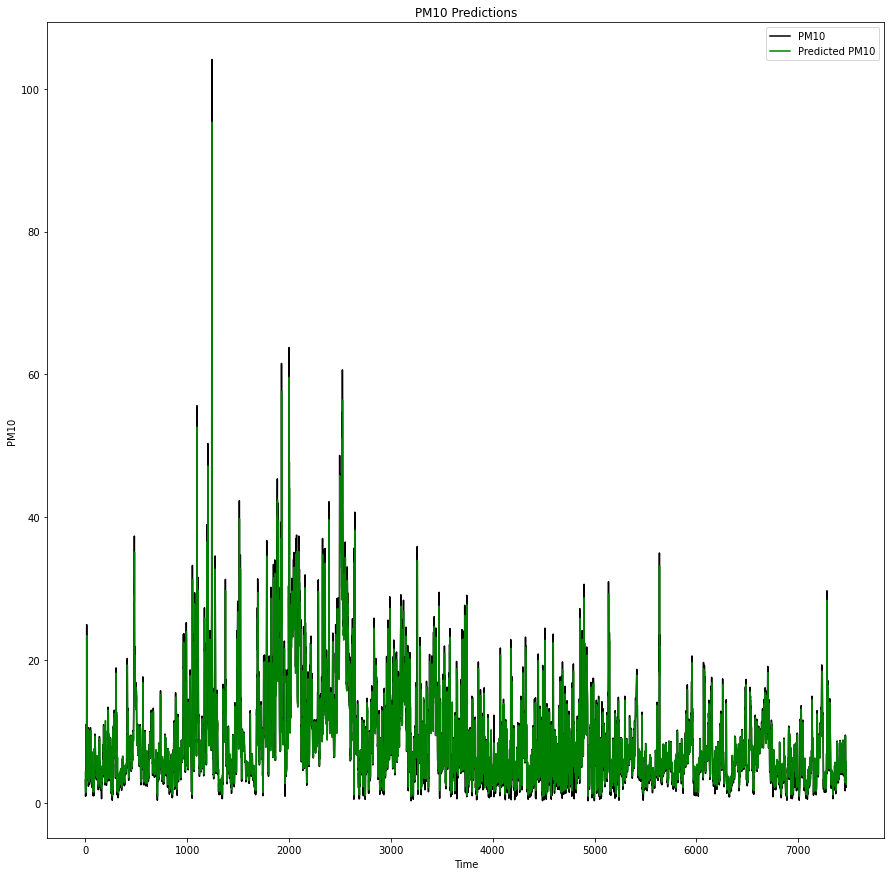

In [9]:
predicted = regressor.predict(X_test_new)
predicted=sc.inverse_transform(predicted)
y_test_new=sc.inverse_transform(y_test_new.reshape(-1,1))
fig = plt.figure(figsize=(15,15))
plt.plot(y_test_new, color = 'black', label = 'PM10')
plt.plot(predicted, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y_test_new, predicted))
print(rmse)

3.2153575467816538


# MODEL CREATION v2 

### UNIVARIATE MODEL

In [85]:
temp_train=one_feature[(one_feature['Start']<= "2018-12-31 23:00:00")]
temp_test=one_feature[(one_feature['Start']>= "2019-12-01 00:00:00")]
temp_train=temp_train.drop('NO2',axis=1)
temp_test=temp_test.drop('NO2',axis=1)

#### Training

In [86]:
from keras.preprocessing.sequence import TimeseriesGenerator
temp = temp_train.copy()
temp=temp.fillna(0)
temp=temp.drop('Start', axis = 1)
temp_X_train = temp
temp_X_train = temp_X_train.values
# temp_y_train = temp[['PM10']].copy() 
# temp_y_train = temp_y_train.values
# temp_y_train = temp_y_train.reshape(-1) 
# temp_y_train = np.insert(temp_y_train, 0, 0)
# temp_y_train = np.delete(temp_y_train, -1)
n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= temp_X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator_train = TimeseriesGenerator(temp_X_train, temp_X_train, length=n_input, batch_size=b_size)

print(generator_train[0][0].shape)

(32, 5, 1)


#### Testing

In [87]:
from keras.preprocessing.sequence import TimeseriesGenerator
temp = temp_test.copy()
temp=temp.fillna(0)
temp=temp.drop('Start', axis = 1)
temp_X_test = temp
temp_X_test = temp_X_test.values
temp_X_test = temp_X_test.reshape(len(temp_X_test))
temp_y_test = temp[['PM10']].copy().values
temp_y_test=temp_y_test.reshape(len(temp_y_test)) 
# temp_y_test = temp_y_test.values
# temp_y_test = temp_y_test.reshape(-1) 
# temp_y_test = np.insert(temp_y_test, 0, 0)
# temp_y_test = np.delete(temp_y_test, -1)
n_input = 5 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= temp_X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 32 # Number of timeseries samples in each batch
generator_test = TimeseriesGenerator(temp_X_test, temp_X_test, length=n_input, batch_size=b_size)

print(generator_test[0][0].shape)

(32, 5)


In [88]:
from keras.layers import Masking
model = Sequential()
model.add(Masking(mask_value=0.,input_shape=(n_input, n_features)))      
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, 5, 1)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [89]:
model.fit_generator(generator_train,epochs=5)

Epoch 1/5
1096/1096 [==============================] - 3s 2ms/step - loss: 29.2037
Epoch 2/5
1096/1096 [==============================] - 3s 2ms/step - loss: 24.4478
Epoch 3/5
1096/1096 [==============================] - 3s 2ms/step - loss: 24.1065
Epoch 4/5
1096/1096 [==============================] - 3s 2ms/step - loss: 24.0779
Epoch 5/5
1096/1096 [==============================] - 3s 2ms/step - loss: 24.3938


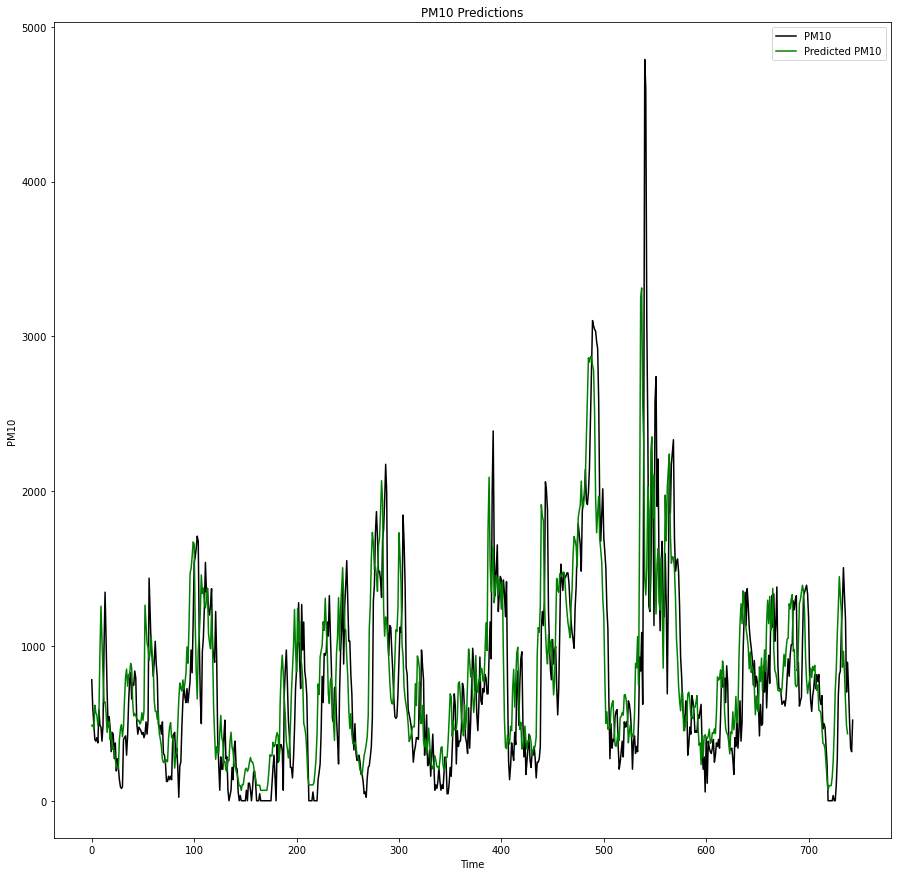

In [90]:
predicted = model.predict(generator_test)
target_points = temp_y_test.targets[1:plot_points+1]
fig = plt.figure(figsize=(15,15))
plt.plot(temp_y_test, color = 'black', label = 'PM10')
plt.plot(predicted, color = 'green', label = 'Predicted PM10')
plt.title('PM10 Predictions')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.legend()
plt.show()

In [91]:
predicted

array([[ 484.78912],
       [ 491.28705],
       [ 464.43893],
       [ 617.54645],
       [ 569.2119 ],
       [ 552.4444 ],
       [ 487.8967 ],
       [ 552.73224],
       [ 954.8076 ],
       [1257.5763 ],
       [1034.8387 ],
       [ 817.3545 ],
       [ 633.96814],
       [ 637.6182 ],
       [ 569.7542 ],
       [ 441.87256],
       [ 508.08084],
       [ 511.52075],
       [ 394.951  ],
       [ 444.3245 ],
       [ 332.03082],
       [ 355.67142],
       [ 323.153  ],
       [ 267.1419 ],
       [ 229.20557],
       [ 208.50993],
       [ 207.17065],
       [ 396.03104],
       [ 462.0935 ],
       [ 491.35544],
       [ 413.17444],
       [ 481.11084],
       [ 656.5799 ],
       [ 796.1178 ],
       [ 850.6104 ],
       [ 740.4928 ],
       [ 815.37286],
       [ 817.6447 ],
       [ 887.41064],
       [ 857.6395 ],
       [ 634.9307 ],
       [ 548.6568 ],
       [ 564.3875 ],
       [ 549.9898 ],
       [ 533.49945],
       [ 515.08545],
       [ 520.749  ],
       [ 496.